![Cloud-First](https://github.com/tulip-lab/sit742/blob/develop/Jupyter/image/CloudFirst.png?raw=1)


# SIT742: Modern Data Science
**(Module: Generative Adversarial Network)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.
- If you found any issue/bug for this document, please submit an issue at [tulip-lab/sit742](https://github.com/tulip-lab/sit742/issues)


Prepared by **SIT742 Teaching Team**

---



## Session 6E: Tabular Data Generation on GAN

## Prepare for the used library

In [1]:
!git clone https://github.com/chriszhangpodo/GANBLR_LIBRARY.git

Cloning into 'GANBLR_LIBRARY'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 8), reused 24 (delta 7), pack-reused 0
Receiving objects: 100% (25/25), 40.40 KiB | 10.10 MiB/s, done.
Resolving deltas: 100% (8/8), done.


Run setup file to install the modules

In [2]:
!python /content/GANBLR_LIBRARY/setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [ ]:
#!pip install pgmpy

Copy and Move the installed library and modules to default work path

In [3]:
!cp -r /content/GANBLR_LIBRARY/ganblr /content/ganblr

## 1. Introduction of Tabular Data Generation

Tabular data generation refers to the process of creating synthetic data that is organized in rows and columns, similar to how data is structured in spreadsheets or relational databases. There are several reasons why generating tabular data can be valuable:



1.   **Anonymization**: Real datasets often contain sensitive information that cannot be shared publicly or even internally without risking privacy breaches. Generating synthetic data can help create datasets that mimic the properties of the original data without exposing sensitive details.
2.   **System Testing**: Synthetic data can be used to stress test systems, ensuring they can handle large volumes of data and operate correctly under various conditions.

1.   **Model Training**: Synthetic data can be used to train machine learning models when real data is scarce, incomplete, or imbalanced. It helps in creating balanced datasets, especially in scenarios where certain classes are underrepresented.
2.   **Data Augmentation and Enhancing Datasets**: Synthetic data can be used to augment real datasets, increasing the size and diversity of the training data for machine learning models.






### 1.1 Difference between image data generation and tabular data generation

In [1]:
# Below is the tabular data set, check it data types and also the structure
from ganblr import get_demo_data
from ganblr.models import GANBLR

df = get_demo_data('adult')
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,6,7,0,9,2,4,1,1,4,1,13,0,2,39,0
1,7,6,0,9,2,2,4,0,4,1,0,0,0,39,0
2,6,4,0,11,5,0,6,1,4,1,0,0,2,39,0
3,7,4,0,1,0,2,6,0,2,1,0,0,2,39,0
4,4,4,0,9,2,2,10,5,2,0,0,0,2,5,0


In [6]:
# Below is the image data set, check it data types and compare to the above tabular data
from keras.datasets.mnist import load_data
from numpy import expand_dims

def load_real_samples():
 # load mnist dataset
 (trainX, _), (_, _) = load_data()
 # expand to 3d, e.g. add channels dimension
 X = expand_dims(trainX, axis=-1)
 # convert from unsigned ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [0,1]
 X = X / 255.0
 return X

dataset = load_real_samples()

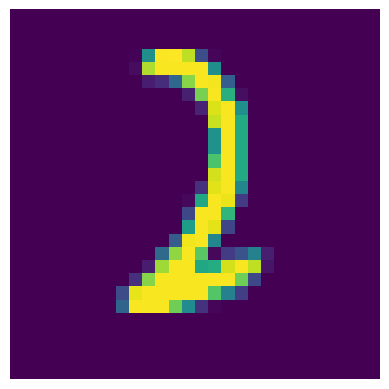

In [12]:
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
import numpy as np
def show_images(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    pyplot.show()

Sample_Original = dataset[np.random.choice(dataset.shape[0], size=25, replace=False)]
show_images(Sample_Original, 1)

As we could see, the Structure and Representation are different between image data and tabular data.
Using default GAN is not suitable for generating the tabular data due to below reasons:



1.   Tabular data has mixture data type. Categorical and Numerical.
2.   Tabular data is 2D and Image is 3D as default. The data value in Image data (pixel value) could indicate the data pattern obviously (direct shape recognized by human). It is quite hard to directly capture the pattern by observation on tabular data.
1.   How to define the quality of the Tabular data? Image data could be viewed easily for its quality (looks like or dislike).



Therefore, we need a new structure of the GAN to generate the tabular data well.





### 1.2 Different methods on tabular data generation

Bayesian Network for Tabular data Generation

Create a student - grade bayesian network

![](https://drive.google.com/uc?export=view&id=1IRSEJSxxG5lOkYq8q0ocEnYTXSfqGnt9)


In [15]:
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3,
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='L', variable_card=2,
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()

True

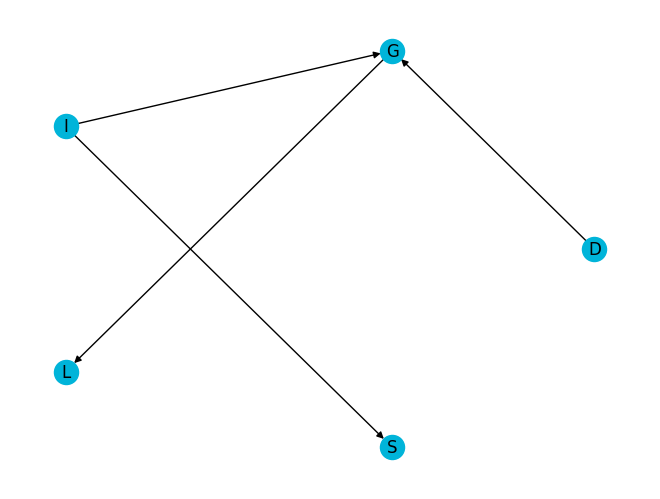

In [16]:
import networkx as nx
# draw model in graph
pos = nx.circular_layout(model)
nx.draw(model, node_color='#00b4d9', pos=pos, with_labels=True)

In [17]:
# Create synthetic data
samples = BayesianModelSampling(model).forward_sample(size=int(100))
samples.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,D,G,I,L,S
0,0,0,1,1,1
1,0,1,0,1,0
2,1,2,0,0,0
3,0,0,0,1,0
4,0,1,0,1,0


## 2. GANBLR: New State of Art for Tabular Data Generation

![](https://drive.google.com/uc?export=view&id=1ceKcsjZntT9dy3eYjjdY_vzUGsERYEog)

The differences of GANBLR comparing to common GAN models are:


1.   The input to generator is the actual original data not random noise
2.   The generator is a discriminatively trained bayesian network learned from the given data.
1.   Objective function will have the conditional log-likelihood from the generator

Therefore, the better trained generator from GANBLR, the better quality of the synthetic data.






In [19]:
# Split the load adult data into train and test for generation
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

x, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

In [20]:
print("Training shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Training shape: (24421, 14) (24421,)
Test shape: (24421, 14) (24421,)


In [22]:
# Train the ganblr with training data for generating the synthetic data
from ganblr.models import GANBLR
model = GANBLR()
model.fit(X_train, y_train, k = 0, epochs = 10, batch_size=64)

warmup run:
382/382 [==============================] - 3s 4ms/step - loss: 0.4375 - accuracy: 0.8084


Epoch 1/10: G_loss = 2.240644, G_accuracy = 0.851030, D_loss = 3.756830, D_accuracy = 0.386942


Epoch 2/10: G_loss = 4.366134, G_accuracy = 0.862823, D_loss = 0.312984, D_accuracy = 0.883091


Epoch 3/10: G_loss = 6.992999, G_accuracy = 0.867123, D_loss = 0.510326, D_accuracy = 0.887237


Epoch 4/10: G_loss = 5.650876, G_accuracy = 0.870317, D_loss = 0.292397, D_accuracy = 0.906355


Epoch 5/10: G_loss = 3.513265, G_accuracy = 0.872036, D_loss = 1.222457, D_accuracy = 0.722161


Epoch 6/10: G_loss = 2.528332, G_accuracy = 0.873551, D_loss = 0.820793, D_accuracy = 0.664781


Epoch 7/10: G_loss = 3.905741, G_accuracy = 0.873510, D_loss = 1.132559, D_accuracy = 0.753487


Epoch 8/10: G_loss = 2.161261, G_accuracy = 0.873920, D_loss = 2.764125, D_accuracy = 0.426381


Epoch 9/10: G_loss = 3.874967, G_accuracy = 0.874821, D_loss = 2.314017, D_accuracy = 0.734139


Epoch 10/10: G_loss = 4.673273, G_accuracy = 0.875476, D_loss = 1.312725, D_accuracy = 0.738873


Once the model is ready, we can use `GANBLR.sample` method to sample some synthetic data.

We can use the `size` parameter to specify the number of samples we want to generate. If we do not specify, it will generate the same number as the training data.

In [23]:
size = 1000

syn_data = model.sample(size)

  0%|          | 0/15 [00:00<?, ?it/s]

In [24]:
import pandas as pd
pd.DataFrame(data = syn_data, columns=df.columns).head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,9,6,0,1,1,5,9,2,2,0,13,8,0,19,0
1,2,3,0,10,0,5,7,5,3,0,17,2,1,34,0
2,1,4,0,3,1,3,6,0,2,1,8,20,3,8,0
3,3,4,0,13,0,5,8,4,2,0,6,9,2,27,0
4,0,0,0,7,1,5,5,0,3,0,8,6,1,25,0
5,1,8,0,3,3,2,6,1,2,1,10,4,1,28,0
6,0,0,0,7,4,5,9,4,1,0,13,20,0,18,0
7,3,2,0,14,0,4,8,2,1,1,9,6,2,28,0
8,4,2,0,11,5,4,1,2,0,0,13,6,1,30,0
9,8,8,0,2,3,6,12,1,4,0,13,1,0,39,0


Finally, as we did in our paper, we will perform a simple TSTR(Train on Synthetic, Test on Real) evaluation to demonstrate the performance of our generated data.

We will evaluate on three models from sklearn, `LogisticRegression`, `RandomForest`, and `MLPClassifier`.

TRTR(Train on Real, Test on Real) will be used as the baseline for comparison.

In [26]:
acc_score_lr = model.evaluate(X_test, y_test, model='lr')
acc_score_mlp = model.evaluate(X_test, y_test, model='mlp')
acc_score_rf = model.evaluate(X_test, y_test, model='rf')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
lbe = LabelEncoder()
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)
y_train_lbe = lbe.fit_transform(y_train)
y_test_lbe = lbe.transform(y_test)

trtr_score_lr  = LogisticRegression().fit(X_train_ohe, y_train_lbe).score(X_test_ohe, y_test_lbe)
trtr_score_rf  = RandomForestClassifier().fit(X_train, y_train_lbe).score(X_test, y_test_lbe)
trtr_score_mlp = MLPClassifier().fit(X_train_ohe, y_train_lbe).score(X_test_ohe, y_test_lbe)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
df_evaluate = pd.DataFrame([
    ['TSTR', acc_score_lr, acc_score_rf, acc_score_mlp],
    ['TRTR', trtr_score_lr,trtr_score_rf,trtr_score_mlp]
], columns=['Evaluated Item', 'LR', 'RF', 'MLP'])
df_evaluate

,Evaluated Item,LR,RF,MLP
0,TSTR,0.865689,0.842103,0.843987
1,TRTR,0.871504,0.848532,0.855166


How to understand the results?


1.   TRTR means: using real data to train the model and test on the real data as well -- common way to do ML task, the result here indicates the best outcome of doing ML task from used model (under same condiction of parameter and training iterations).
2.   TSTR means: using synthetic data to train the model and test on the real data -- if the quality of the synthetic data is good, it should be fully workable by replacing the original data on the model training and the testing results from original data is also close to the TSTR.

How good our GANBLR is? you could see the TSTR and TRTR is really close each other, that is why we call it is the current benchmark!



There are some other tabular data generators:



1.   CTGAN: https://github.com/sdv-dev/CTGAN
2.   TVAE: https://github.com/sdv-dev/CTGAN
1.   PATE-GAN: https://github.com/BorealisAI/private-data-generation
2.   TABLEGAN: https://github.com/mahmoodm2/tableGAN

You could explore the above generators and enjoy the tabular data generation!



